# Visualizing Moores Law

The execise is to take statistics from wikipedias page about transistors ([https://en.wikipedia.org/wiki/Transistor_count](https://en.wikipedia.org/wiki/Transistor_count)). 

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import bs4
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup
import matplotlib.pyplot as plt
import re
import random

### Create dataframe

In [2]:
def createDf():
    '''Creates an empty dataframe with "Name|Transistor_Count|Year|Mos_process" '''
    games_df = pd.DataFrame(columns=['Name', 'Transistor_Count', 'Year', 'Mos_process'])
    games_df = games_df.astype({'Name': 'object','Transistor_Count': 'float64','Year': 'int64','Mos_process': 'float64'})
    return games_df

In [3]:
# Preview of dataframe
createDf()

,Name,Transistor_Count,Year,Mos_process


## Webscrape the page

In [4]:
#wiki_transistor_url = "https://en.wikipedia.org/wiki/Transistor_count" # LIVE URL, changes
#wiki_transistor_url = "https://en.wikipedia.org/w/index.php?title=Transistor_count&oldid=922713728" numbers in Mio(1= 1000000)
wiki_transistor_url = "https://en.wikipedia.org/w/index.php?title=Transistor_count&oldid=922089867" # Older Url,1 000 000
uClient = uReq(wiki_transistor_url)
page_html = uClient.read()
uClient.close()

### Parse the data to a soup objekt

In [5]:
page_soup = soup(page_html, 'html.parser')
# preview of page
page_soup

<!DOCTYPE html>

<html class="client-nojs" dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<title>Transistor count - Wikipedia</title>
<script>document.documentElement.className="client-js";RLCONF={"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"Transistor_count","wgTitle":"Transistor count","wgCurRevisionId":923241677,"wgRevisionId":922089867,"wgArticleId":4469365,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["All articles with dead external links","Articles with dead external links from May 2019","CS1 German-language sources (de)","Use mdy dates from January 2015","Articles containing potentially dated statements from 2019","All articles containing potentially dated statements","Articles containing potentially dated statements from 2018","Articles containing potentially dated statements from 2016","All accuracy disputes","Articles with disputed statements from August 2019",

## Find table from the page and save it

In [6]:
# Find Table from page
table = page_soup.find("table", {"class":"wikitable sortable"}).tbody
# Remove the top row(it has only headers which are not needed)
table_tr = table.findAll("tr")[1:]
# Preview our parsed table data
table_tr

[<tr>
 <td><a class="mw-redirect" href="/wiki/MP944" title="MP944">MP944</a> (20-bit, <i>6-chip</i>)
 </td>
 <td><i><b>?</b></i>
 </td>
 <td>1970<sup class="reference" id="cite_ref-F-14_18-1"><a href="#cite_note-F-14-18">[18]</a></sup> <small><br/>(<a href="/wiki/Declassification" title="Declassification">declassified</a><br/>1998)</small>
 </td>
 <td><a href="/wiki/Garrett_AiResearch" title="Garrett AiResearch">Garrett AiResearch</a>
 </td>
 <td><i><b>?</b></i>
 </td>
 <td><i><b>?</b></i>
 </td></tr>, <tr>
 <td><a href="/wiki/Intel_4004" title="Intel 4004">Intel 4004</a> (4-bit, 16-pin)
 </td>
 <td>2,250
 </td>
 <td>1971
 </td>
 <td><a href="/wiki/Intel" title="Intel">Intel</a>
 </td>
 <td><a href="/wiki/10_%C2%B5m_process" title="10 µm process">10,000 nm</a>
 </td>
 <td>12 mm²
 </td></tr>, <tr>
 <td><a href="/wiki/Intel_8008" title="Intel 8008">Intel 8008</a> (8-bit, 18-pin)
 </td>
 <td>3,500
 </td>
 <td>1972
 </td>
 <td>Intel
 </td>
 <td>10,000 nm
 </td>
 <td>14 mm²
 </td></tr>, <tr

## Create methods for data parsing


### Transistor count filter method

In [7]:
def transistorCountFilter(obj):
    '''Takes in a <td> object and returns a objekt that is parsed. Returns a objekt that is a number'''
    transistor_obj = obj
    try:
        # Remove unwanted span tags from objekt
        unwanted = obj.span
        unwanted.extract()
    except:
        # If no span was found, pass to next step
        pass

    try:
        # Regex to search only for the numbers and ",.". First match is saved
        transistor_obj = re.search("[0-9.,]+", transistor_obj.getText()).group(0)
        # Remove "," to be able to convert numbers to floats
        transistor_obj = transistor_obj.replace(",","")
    except:
        # If regex does not find match, Save as NaN
        transistor_obj = np.nan
        
    return transistor_obj

## Mos process filter

In [8]:
def mosProcessFilter(obj):
    '''Takes in a <td> object and returns a objekt that is parsed. Returns a objekt that is a number'''
    try:
        # Take objects text, regex match for numbers and remove "," to be able to convert to float
        mos_obj = obj.getText()
        mos_obj = re.search("[0-9.,]+", mos_obj).group(0)
        mos_obj = mos_obj.replace(",","")
    except:
        # If no text is found or regex does not find match, Save as NaN
        mos_obj = np.nan
        
    return mos_obj

## Name filter

In [9]:
def nameFilter(obj):
    '''Takes in a <td> object and returns a objekt that is parsed. Returns a objekt that is a string'''
    # Get Text from object
    name_obj = obj.getText()
    
    try:
        # Regex search everything between start and " ("
        name_obj = re.search("(?<=)(.*?)(?= \()", name_obj).group(0)
    except:
        pass
    
    # Remove new lines from string
    name_obj = name_obj.strip("\n")
    
    return name_obj

## Loop through the data


In [10]:
transistor_dataframe = createDf()

iterator = 0
for tr in table_tr:
    # Save current elements td in variable
    td_all = tr.findAll("td")
    
    if((len(td_all) == 6) ):
        # NAME
        name = nameFilter(td_all[0])
        
        # TRANSISTOR COUNT
        transistor_count = transistorCountFilter(td_all[1])

        # YEAR
        year = td_all[2].getText()[:4]
        
        # MOS PROCESS
        mos = mosProcessFilter(td_all[4])
        
    # If len(td) is not 6 we will take previous name and year
    else:
        # Asign values
        name = nameFilter(table_tr[iterator - 1].findAll("td")[0])
        transistor_count = transistorCountFilter(table_tr[iterator - 1].findAll("td")[1])
        year = table_tr[iterator - 1].findAll("td")[2].getText()[:4]
        mos = mosProcessFilter(td_all[0])
        
    # Increment iterator. Used for when previous data is needed in else statement
    iterator =  iterator + 1
    
    # Create data objekt and append to our newly created dataframe
    data = {
        'Name': name,
        'Transistor_Count': float(transistor_count), 
        'Year': int(year),
        'Mos_process': float(mos)
    }
    transistor_dataframe = transistor_dataframe.append(data, ignore_index=True)

### Inspect the data

In [11]:
transistor_dataframe.dtypes

Name                 object
Transistor_Count    float64
Year                  int64
Mos_process         float64
dtype: object

In [12]:
transistor_dataframe.head()

,Name,Transistor_Count,Year,Mos_process
0,MP944,NaN,1970,NaN
1,Intel 4004,2250.0,1971,10000.0
2,Intel 8008,3500.0,1972,10000.0
3,NEC μCOM-4,2500.0,1973,7500.0
4,Toshiba TLCS-12,11000.0,1973,6000.0


In [13]:
transistor_dataframe.tail()

,Name,Transistor_Count,Year,Mos_process
181,Fujitsu A64FX,8.786000e+09,2018,7.0
182,GC2 IPU,2.360000e+10,2018,16.0
183,Tegra Xavier SoC,9.000000e+09,2018,12.0
184,Samsung Exynos 9820,NaN,2019,8.0
185,AMD Epyc Rome,3.200000e+10,2019,7.0


#### Exceptions

There is an exception int the data we want to remove. A processor named "Zip CPU". This processor has its transistor count in LUT which is different from the rest of the data. The data will be changed to NAN so we can still take it to account in other calculations.

In [14]:
print(transistor_dataframe[transistor_dataframe["Name"] == "Zip CPU"])
transistor_dataframe.at[154, "Transistor_Count"] = np.nan

        Name  Transistor_Count  Year  Mos_process
154  Zip CPU            1286.0  2016          NaN


In [15]:
transistor_dataframe[transistor_dataframe["Name"] == "Zip CPU"]

,Name,Transistor_Count,Year,Mos_process
154,Zip CPU,NaN,2016,NaN


##  Graphs

In [16]:
# Save a copy of dataframe
processor_per_decade = transistor_dataframe
# Drop unnecessary columns
processor_per_decade = processor_per_decade.drop({"Name", "Transistor_Count", "Mos_process"} , axis=1)
# Group by decades by dividing Year with 10 as int and the multipling it bak up (ex. 1976//10 = 197 => 197 * 10 = 1970)
processor_per_decade = processor_per_decade.groupby(processor_per_decade["Year"]//10 *10).count()
# Rename second column to amount 
processor_per_decade = processor_per_decade.rename(columns={"Year": "Amount"})
# Preview data
processor_per_decade

,Amount
Year,
1970,23
1980,25
1990,26
2000,37
2010,75


### Draw a graph that shows processors invented per decade

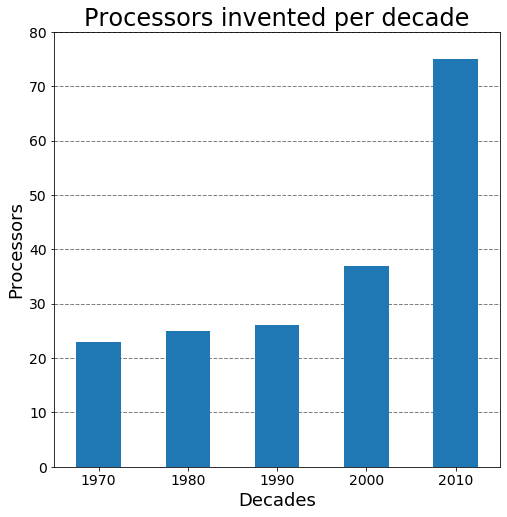

In [17]:
amount_plot = processor_per_decade.plot(kind='bar', figsize=(8, 8), zorder=3) # Create graph
amount_plot.get_legend().remove() # Remove legend, tabel is easy to read and does not need more clutter
plt.grid(color='black', linestyle='--', linewidth=1, axis='y',zorder=0, alpha=0.5) # Add grid for easy readability
plt.ylim(top=80) # Limit y scale at 80
plt.yticks(fontsize=14) # Change x and y scales fontsize to make graph easier to read
plt.xticks(fontsize=14, rotation=360) 
plt.ylabel("Processors", fontsize=18) # Label the axes
plt.xlabel("Decades",fontsize=18)
plt.title("Processors invented per decade", fontsize=24) # Add title
plt.show()

## Graph for processor transistor production accuracy

Vi börjar med att modifiera till oss en passlig dataframe. Vi tar minsta värdet som finns för att visa årets största framgång

In [18]:
# Drop NaN values
mos_process_per_year = transistor_dataframe.dropna()
# Remove unnecessary columns
mos_process_per_year = mos_process_per_year.drop({"Name", "Transistor_Count"} , axis=1)
# Group by year, then take min value and round the floating points
mos_process_per_year = mos_process_per_year.groupby(mos_process_per_year["Year"]).min().round(2)
# Preview data
mos_process_per_year.head()

,Mos_process
Year,
1971,10000.0
1972,10000.0
1973,6000.0
1974,6000.0
1975,8000.0


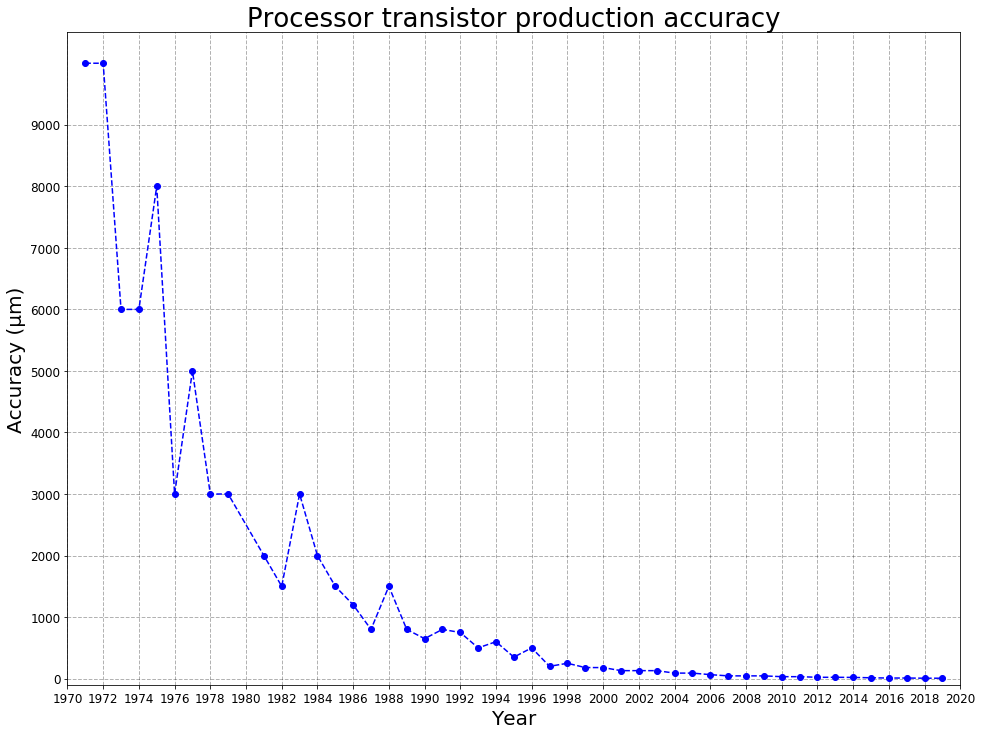

In [19]:
accuracy_plot = mos_process_per_year.plot(kind="line", linestyle='--', marker='o', color='b',  figsize=(16, 12), zorder=3) # Create graph
accuracy_plot.get_legend().remove() # Remove legend, tabel is easy to read and does not need more clutter
plt.grid(color='black', linestyle='--', linewidth=1, axis='both',zorder=0, alpha=0.3) # Add grid for easy readability
plt.ylim(bottom=-100) # Limit y at bottom at -100 so that we can easier see that graph is nearing 0
plt.xticks(np.arange(1970, 2021, step=2), fontsize=12) # Add custom x and y ticks for easier readability
plt.yticks(np.arange(0, 10000, step=1000),fontsize=12) # Change x and y scales fontsize to make graph easier to read
plt.ylabel("Accuracy (μm)", fontsize=20) # Label the axes
plt.xlabel("Year", fontsize=20)
plt.title("Processor transistor production accuracy", fontsize=26) # Add title
plt.show()

## Graph to prove Moores Law

**Moores law:** Moore's law is the observation that the number of transistors in a dense integrated circuit doubles about every two years.

In [20]:
# Drop NaN values
transistor_count = transistor_dataframe.dropna()
# Remove unncessary columns
transistor_count = transistor_count.drop({"Name", "Mos_process"} , axis=1)
# Preview data
transistor_count.head()

,Transistor_Count,Year
1,2250.0,1971
2,3500.0,1972
3,2500.0,1973
4,11000.0,1973
5,3000.0,1974


In [21]:
transistor_count.dtypes

Transistor_Count    float64
Year                  int64
dtype: object

### Draw the graph

We will use a scatter plot for our data and a line to draw the Moores law prediction. 

The function for the line is :

n = M0 * 2^( (y-y0) / 2) )

where :
* n = amount of transistors at y
* M0 = y0 start years transistor count
* y = the year we want to find its transistor count

To calculate this we need one start year with its transistor count.


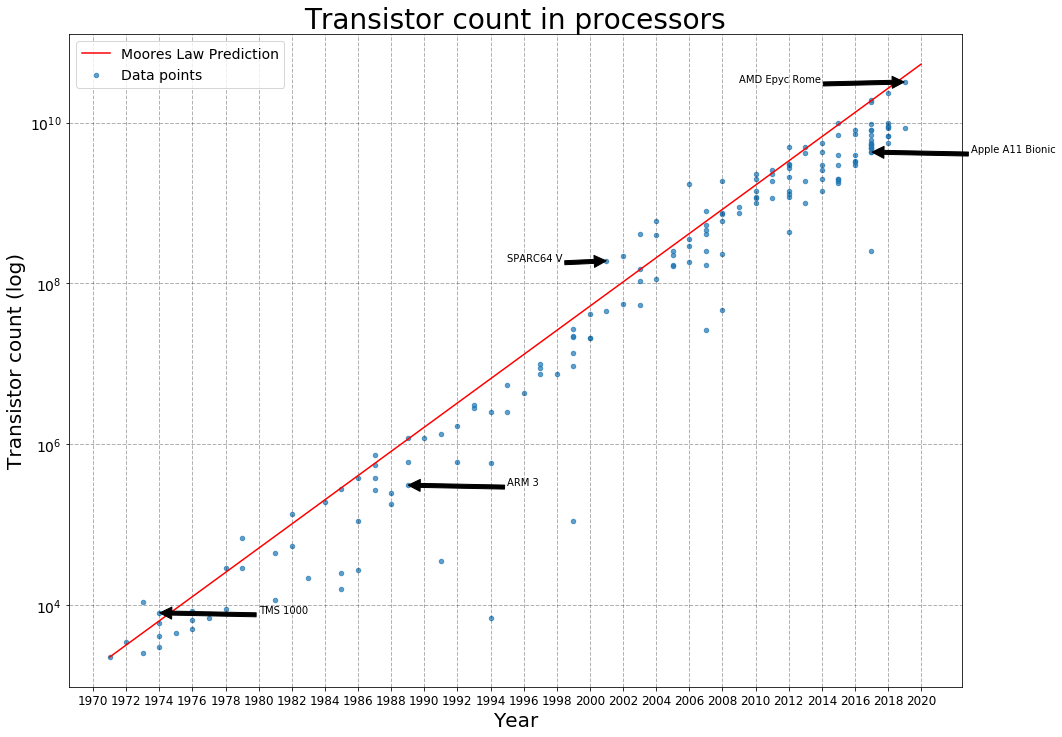

In [22]:
transistor_count.plot(kind='scatter', x='Year',y='Transistor_Count', figsize=(16, 12), label="Data points", alpha= 0.7)

# Calculate Moores law equation ( n = mo * t) 
years = np.arange(1971, 2021, step=1)
yo = 1971
mo = 2250
t = pow(2,(years - yo)/2) 
moore = mo * t 
plt.plot(years, moore, '-r', label="Moores Law Prediction" ) # draw Moores law


plt.legend(fontsize=14) # Change legend size for easier readability
plt.yticks(fontsize=14) # Change x y ticks font size
plt.xticks(np.arange(1970, 2021, step=2), fontsize=12) 
plt.grid(color='black', linestyle='--', linewidth=1, axis='both', alpha=0.3) # Add grid for easy readability of values
plt.ylabel("Transistor count (log)", fontsize=20) # label x and y
plt.xlabel("Year", fontsize=20) 
plt.title("Transistor count in processors", fontsize=28) # Add title
plt.yscale('log') # Change to Log scale on y 

# Annotate dataframe
annotate_df = transistor_dataframe.dropna()

# random values from 3 different year spans, used for random annotates
start_v = random.randrange(0, 29) # 0-28, from start to 1986
middle_v = random.randrange(29, 61) # 29-61, from 1987 -> 2000
end_v = random.randrange(61, len(annotate_df) + 1)  # 62 - end, from 2000 to end

# Random annotate for data from start to 1986
plt.annotate(annotate_df.iloc[start_v].Name, 
             xy=(annotate_df.iloc[start_v].Year, annotate_df.iloc[start_v].Transistor_Count),
             xytext=(annotate_df.iloc[start_v].Year + 6  , annotate_df.iloc[start_v].Transistor_Count),
             arrowprops=dict(facecolor='black', shrink=0.005)
            )

# Random annotate for data from 1987 -> 2000
plt.annotate(annotate_df.iloc[middle_v].Name, 
             xy=(annotate_df.iloc[middle_v].Year, annotate_df.iloc[middle_v].Transistor_Count),
             xytext=(annotate_df.iloc[middle_v].Year + 6  , annotate_df.iloc[middle_v].Transistor_Count),
             arrowprops=dict(facecolor='black', shrink=0.005)
            )

# Random annotate for data from 2000 to end
plt.annotate(annotate_df.iloc[end_v].Name, 
             xy=(annotate_df.iloc[end_v].Year, annotate_df.iloc[end_v].Transistor_Count),
             xytext=(annotate_df.iloc[end_v].Year + 6, int(annotate_df.iloc[end_v].Transistor_Count)),
             arrowprops=dict(facecolor='black', shrink=0.005)
            )

# Annotate AMD Epyc Rome processor
plt.annotate(annotate_df.iloc[167].Name, 
             xy=(annotate_df.iloc[167].Year, annotate_df.iloc[167].Transistor_Count),
             xytext=(annotate_df.iloc[167].Year - 10, int(annotate_df.iloc[167].Transistor_Count)),
             arrowprops=dict(facecolor='black', shrink=0.005)
            )

# Annotate for Sparc64 v processor
plt.annotate(annotate_df.iloc[64].Name, 
             xy=(annotate_df.iloc[64].Year, annotate_df.iloc[64].Transistor_Count),
             xytext=(annotate_df.iloc[64].Year - 6, int(annotate_df.iloc[64].Transistor_Count)),
             arrowprops=dict(facecolor='black', shrink=0.005)
            )



plt.show()